In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from scipy.optimize import minimize, differential_evolution


from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter, landscape
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
import os
# Define the title for the entire PDF
pdf_title = "15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13"
# Define the base directory
base_dir = '/home/jwm/data/fluorescence_plots/'
# Construct the figure directory path
figure_dir = os.path.join(base_dir, pdf_title)
# Ensure the figure directory exists
os.makedirs(figure_dir, exist_ok=True)# Directory for joined pdfs
# Directory for joined pdfs
output_dir = '/home/jwm/data/fluorescence_plots/fluorescence_data_overview_21_may_2024/'
os.makedirs(output_dir, exist_ok=True)


In [2]:
# Load and organize data, set parameters and choose subset

# Set the directory where your data files are located
data_dir = '/home/jwm/data/JASCO_FP_6500_Spectrofluorometer/2024april13_50mM_DAB2_418_630_150mM_NaCl_1DCVJ_slow_hysteresis/'

# Set the number of the first and last spectrum to use in the plot -1
# first_spectrum = 0
# last_spectrum = 30

# Define the range of titles you want to load
start_title = 7
end_title = 30

# Function to load (x, y) data from txt file starting from the 19th line
def load_data(file_path):
    return np.loadtxt(file_path, skiprows=18)

# Get all txt files in the directory
data_files = glob.glob(data_dir + "*.txt")

# Initialize a list to store loaded data
loaded_data = []

# Initialize variables for baseline data
baseline_data = None
baseline_title = None

titles = []

# Load data and extract titles
for file_path in data_files:
    data = load_data(file_path)
    # Check if file name contains "999" and assign it as baseline data
    if "999" in file_path:
        baseline_data = data
    else:
        # Extract 6th to 4th last digits from file name and use as title
        title = int(file_path.split('/')[-1].split('.')[0][-7:-4])
        titles.append(title)
        loaded_data.append(data)
        
# Print the baseline title to check if it is set correctly
print("Baseline data loaded:", baseline_data is not None)

# Subtract the baseline spectrum from each spectrum if baseline_data is available
if baseline_data is not None:
    baseline_spectrum = baseline_data[:, 1]  # Assuming y-values are in the second column
    for i in range(len(loaded_data)):
        loaded_data[i][:, 1] -= baseline_spectrum

# Sort the titles and loaded_data in ascending order
sorted_indices = np.argsort(titles)
titles = [titles[i] for i in sorted_indices]
loaded_data = [loaded_data[i] for i in sorted_indices]

# Print sorted titles to verify sorting
print("Sorted titles:", titles)

# Convert extracted digits back to temperature values
temperatures = [10 + i * 0.5 for i in range(len(titles))]

# Extract x-values from the first spectrum in loaded_data
wavelengths = loaded_data[0][:, 0].astype(float)

print(wavelengths)

# Sample loaded_data structure
# loaded_data = [
#    np.array([[470.0, 422.133], [470.1, 422.08], [470.2, 422.001], [650.0, 7.49391]]),
#    np.array([[470.0, 430.678], [470.1, 430.75], [470.2, 430.611], [650.0, 7.97855]])
#]

# Function to create DataFrame
def create_dataframe(loaded_data, titles):  # spectra in rows
    # Initialize DataFrame with the first spectrum
    df = pd.DataFrame(loaded_data[0], columns=['wavelength', titles[0]])
    
    # Iterate over the remaining spectra and concatenate them to the DataFrame
    for i in range(1, len(loaded_data)):
        spectrum_df = pd.DataFrame(loaded_data[i], columns=['wavelength', titles[i]])
        df = pd.merge(df, spectrum_df, on='wavelength', how='outer')
    
    return df

# selected_data = [loaded_data[titles.index(title)] for title in included_titles]

title_inputs = input("Enter the titles to include (separated by space), and ranges separated by '-': ").split()
included_titles = [title for title_input in title_inputs for title in (list(range(int(title_input.split('-')[0]), int(title_input.split('-')[-1])+1)) if '-' in title_input else [int(title_input)])]

def get_selected_data(loaded_data, titles_input):
    selected_data = []
    selected_temperatures = []
    for title_input in titles_input:
        if '-' in str(title_input):
            start, end = map(int, title_input.split('-'))
            selected_data.extend(loaded_data[start-1:end])
            selected_temperatures.extend(temperatures[start-1:end])
        else:
            selected_data.append(loaded_data[int(title_input)-1])
            selected_temperatures.append(temperatures[int(title_input)-1])
    return selected_data, selected_temperatures
    
selected_data, selected_temperatures = get_selected_data(loaded_data, included_titles)

df = create_dataframe(selected_data, included_titles)
df = df.transpose()
print(df)



Baseline data loaded: True
Sorted titles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 100]
[470.  470.1 470.2 ... 649.8 649.9 650. ]


Enter the titles to include (separated by space), and ranges separated by '-':  1-40


               0        1        2        3        4        5        6     \
wavelength  470.000  470.100  470.200  470.300  470.400  470.500  470.600   
1           120.254  120.547  120.952  122.227  122.539  124.786  126.108   
2           128.799  129.217  129.562  130.126  131.033  132.968  134.314   
3           148.973  149.599  149.811  150.296  150.950  153.083  153.082   
4           179.545  179.431  179.918  180.942  181.789  183.595  184.277   
5           205.592  205.307  205.286  205.884  206.314  207.546  208.689   
6           225.090  225.038  225.668  225.446  225.762  227.169  228.132   
7           195.168  194.703  195.052  195.043  195.302  197.082  198.064   
8           198.170  198.196  198.376  198.953  198.193  199.976  200.440   
9           161.292  161.528  161.809  162.295  162.335  164.219  163.983   
10          118.461  117.889  117.955  118.942  118.885  120.209  121.335   
11           81.717   81.959   81.893   82.294   81.857   82.903   83.316   

In [15]:
## Project onto Exponential and Lorentzians

# Lorentzian function
def lorentzian(x, x0, gamma):
    return 1 / (np.pi * gamma * (1 + ((x - x0) / gamma) ** 2))

# Exponential function
def exponential(x, a, b, c):
    return a * np.exp(-b * (x - c))

# Initial guess for parameters
initial_x0 = 490 # wavelengths.mean()  # Mean of the wavelengths
initial_gamma0 = (wavelengths.max() - wavelengths.min()) / 5  # Range of wavelengths divided by 10
initial_x1 = 505 # wavelengths.mean()  # Initial guess for the second Lorentzian's center
initial_gamma1 = (wavelengths.max() - wavelengths.min()) / 20  # Initial guess for the second Lorentzian's width
initial_a0 = 30.0  # Initial guess for the amplitude of the exponential
initial_b0 = 0.1  # Initial guess for the decay rate of the exponential
initial_c0 = 400 # wavelengths.mean()  # Initial guess for the center of the exponential
initial_a1 = 10.0  # Initial guess for the amplitude of the exponential
initial_b1 = 0.2  # Initial guess for the decay rate of the exponential
initial_c1 = 600 # wavelengths.mean()  # Initial guess for the center of the exponential
num_spectra = len(included_titles)
initial_scales = np.ones((4, num_spectra))  # Initial guess for scaling factors for each Lorentzian
initial_params = [initial_x0, initial_gamma0, initial_x1, initial_gamma1, initial_a0, initial_b0, initial_c0, initial_a1, initial_b1, initial_c1] + initial_scales.flatten().tolist()

# Bounds for parameters
bounds = [
    (480, 500),   # bounds for x0
    (1, 100),     # bounds for gamma0
    (490, 520),   # bounds for x1
    (1, 100),     # bounds for gamma1
    (0, 100),     # bounds for a0
    (0, 1),       # bounds for b0
    (200, 600),   # bounds for c0
    (0, 100),     # bounds for a1
    (0, 1),       # bounds for b1
    (400, 800)    # bounds for c1
]
# Additional bounds for scaling factors for each function and spectrum
for _ in range(num_spectra):
    bounds.extend([
        (-10.0, 50.0),   # Scaling factor for Lorentzian 1
        (-10.0, 50.0),   # Scaling factor for Lorentzian 2
        (-10.0, 20.0),   # Scaling factor for Exponential 1
        (-10.0, 20.0)    # Scaling factor for Exponential 2
    ])


# Filter the wavelengths and spectra to include only the range 475-525 nm
mask = (wavelengths >= 475) & (wavelengths <= 525)
filtered_wavelengths = wavelengths[mask]
filtered_spectra = df.iloc[:, mask]


# Objective function to minimize
def objective(params, df):
    x0, gamma0, x1, gamma1, a0, b0, c0, a1, b1, c1 = params[:10]
    scales = np.array(params[10:]).reshape((4, -1))  # Reshape scales into 2D array (2 rows, num_spectra columns)
    residuals = 0
    
    for i, title in enumerate(df.index[1:]):
        y_data = df.loc[title].values.astype(float)  # Spectral data
        y_fit = (scales[0, i] * lorentzian(wavelengths, x0, gamma0) + 
                 scales[1, i] * lorentzian(wavelengths, x1, gamma1) + 
                 scales[2, i] * exponential(wavelengths, a0, b0, c0)+ 
                 scales[3, i] * exponential(wavelengths, a1, b1, c1))
        residuals += np.sum((y_data - y_fit) ** 2)
    
    return residuals
# Perform the optimization
result = minimize(objective, initial_params, args=(df,), method='L-BFGS-B', bounds=bounds)



# Extract the optimized parameters
optimized_x0 = result.x[0]
optimized_gamma0 = result.x[1]
optimized_x1 = result.x[2]
optimized_gamma1 = result.x[3]
optimized_a0 = result.x[4]
optimized_b0 = result.x[5]
optimized_c0 = result.x[6]
optimized_a1 = result.x[7]
optimized_b1 = result.x[8]
optimized_c1 = result.x[9]
optimized_scales = np.array(result.x[10:]).reshape((4, -1))  # Reshape scales into 2D array (2 rows, num_spectra columns)

#print(result.x[10:])

# Output the results
print("Optimized x0 (Lorentzian 1):", optimized_x0)
print("Optimized gamma (Lorentzian 1):", optimized_gamma0)
print("Optimized x1 (Lorentzian 2):", optimized_x1)
print("Optimized gamma (Lorentzian 2):", optimized_gamma1)
print("Optimized a0 (Exponential):", optimized_a0)
print("Optimized b0 (Exponential):", optimized_b0)
print("Optimized c0 (Exponential):", optimized_c0)
print("Optimized a1 (Exponential):", optimized_a1)
print("Optimized b1 (Exponential):", optimized_b1)
print("Optimized c1 (Exponential):", optimized_c1)
print("Optimized scales:", optimized_scales)

[ 20.50401234  20.50644103   8.56893103   8.56939084  20.50425182
  20.50428119   8.56853096   8.56852173  20.50516716  20.50429849
   8.56484218   8.56510164  16.87420636  13.9314439    8.56364261
   8.5649078   20.50326621  20.50298867   8.56394918   8.56380098
  20.50258675  20.50233319   8.56344369   8.56481652  20.5051365
  20.50501768   8.56448848   8.56444755  20.12488853   3.19123439
  -0.09263524  -0.09267022   3.19105345   3.19095138  -0.09292618
  -0.09297086   3.1907525    3.19070318  -0.09313202  -0.09721412
  20.50915032  20.51182039   8.57505208   8.57563335  20.50886418
  20.50884747   8.57405224   8.57398638  20.50934285  20.50810377
   8.568352     8.56865976  20.5016241   20.50034846   8.56627869
   8.56789373  20.50549588  20.50506358   8.5664383    8.56618386
  20.50442471  20.50402611   8.56557905   8.56729764  20.50754761
  20.50734008   8.56676267   8.56669109  20.50683042  20.506583
   8.56601037   8.56593672  20.50625215  20.50609084   8.56550255
   8.56542825

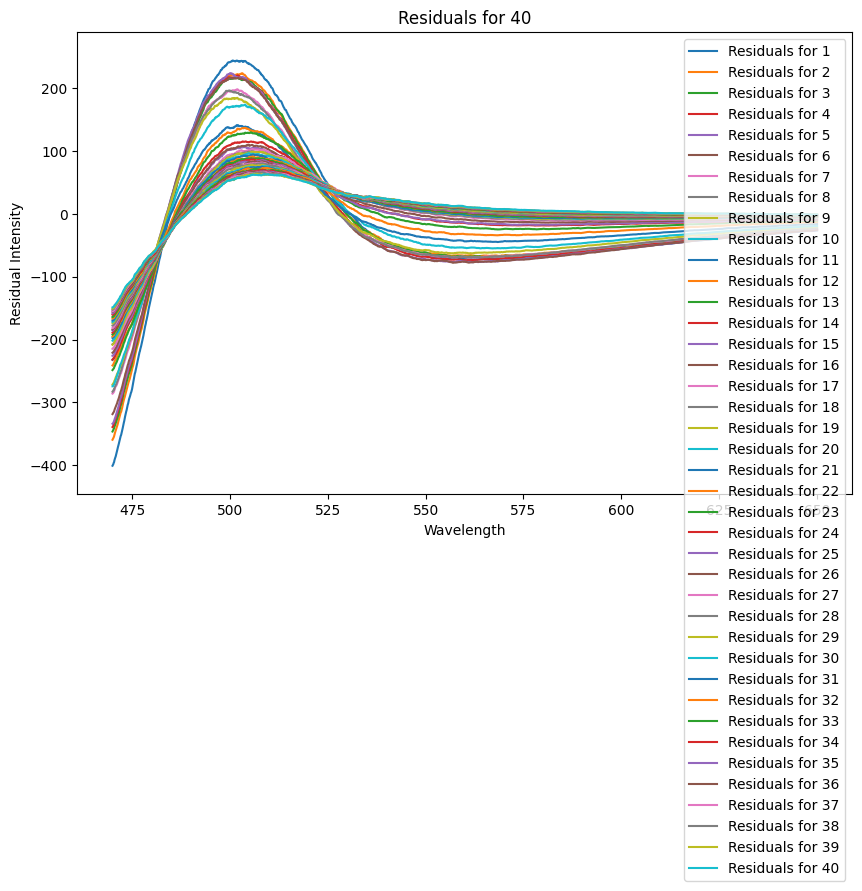

In [10]:
# Calculate the fitted curves and residues
fitted_curves = []
residues = []

for i, title in enumerate(df.index[1:]):
    y_data = df.loc[title].values.astype(float)  # Original spectral data
    y_fit = (optimized_scales[0, i] * lorentzian(wavelengths, optimized_x0, optimized_gamma0) + 
             optimized_scales[1, i] * lorentzian(wavelengths, optimized_x1, optimized_gamma1) + 
             optimized_scales[2, i] * exponential(wavelengths, optimized_a0, optimized_b0, optimized_c0)+ 
             optimized_scales[3, i] * exponential(wavelengths, optimized_a1, optimized_b1, optimized_c1))
    fitted_curves.append(y_fit)
    residues.append(y_data - y_fit)

# Calculate the global min and max of the residues
all_residues = np.concatenate(residues)
res_min = all_residues.min()
res_max = all_residues.max()

# Determine the 10% margin
margin = 0.07 * (res_max - res_min)
y_min = res_min - margin
y_max = res_max + margin

# Plot the residuals for each spectrum
plt.figure(figsize=(10, 6))
for i, title in enumerate(included_titles):
    plt.plot(wavelengths, residues[i], label=f'Residuals for {title}')
plt.xlabel('Wavelength')
plt.ylabel('Residual Intensity')
plt.legend()
plt.title(f'Residuals for {title}')
plt.ylim(y_min, y_max)  # Set the y-axis limits
plt.show()


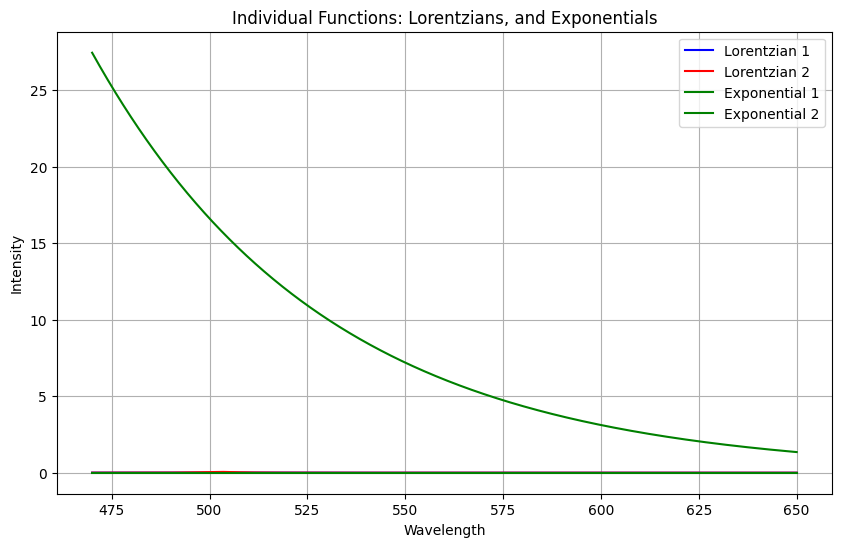

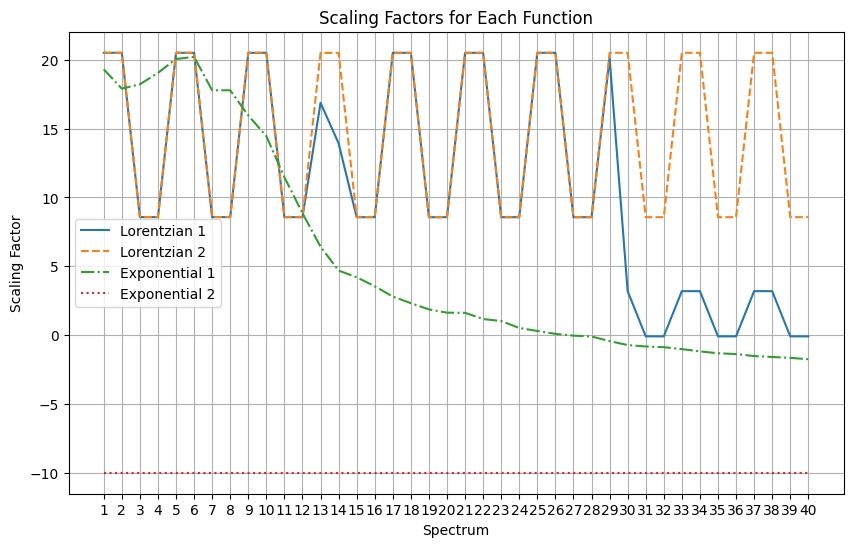

In [18]:
## Plot fitted functions and scaling factors

# Generate x values for plotting
x_values = np.linspace(wavelengths.min(), wavelengths.max(), 1000)

# Calculate the individual functions using the optimized parameters
lorentzian1_values = lorentzian(x_values, optimized_x0, optimized_gamma0)
lorentzian2_values = lorentzian(x_values, optimized_x1, optimized_gamma1)
exponential1_values = exponential(x_values, optimized_a0, optimized_b0, optimized_c0)
exponential2_values = exponential(x_values, optimized_a1, optimized_b1, optimized_c1)

# Plot the individual functions
plt.figure(figsize=(10, 6))

# Plot Lorentzian 1
plt.plot(x_values, lorentzian1_values, label='Lorentzian 1', color='blue')

# Plot Lorentzian 2
plt.plot(x_values, lorentzian2_values, label='Lorentzian 2', color='red')

# Plot Exponential 1
plt.plot(x_values, exponential1_values, label='Exponential 1', color='green')

# Plot Exponential 2
plt.plot(x_values, exponential2_values, label='Exponential 2', color='green')

plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.title('Individual Functions: Lorentzians, and Exponentials')
plt.legend()
plt.grid(True)
plt.show()


# Get the number of spectra
num_spectra = len(df.index) - 1  # Exclude the first row (wavelengths)

# Extract the scaling factors for each function
scales_lorentzian1 = optimized_scales[0]
scales_lorentzian2 = optimized_scales[1]
scales_exponential1 = optimized_scales[2]
scales_exponential2 = optimized_scales[3]

# Plot the scaling factors for each function
plt.figure(figsize=(10, 6))

plt.plot(range(1, num_spectra + 1), scales_lorentzian1, linestyle='-', label='Lorentzian 1')
plt.plot(range(1, num_spectra + 1), scales_lorentzian2, linestyle='--', label='Lorentzian 2')
plt.plot(range(1, num_spectra + 1), scales_exponential1, linestyle='-.', label='Exponential 1')
plt.plot(range(1, num_spectra + 1), scales_exponential2, linestyle=':', label='Exponential 2')

plt.xlabel('Spectrum')
plt.ylabel('Scaling Factor')
plt.title('Scaling Factors for Each Function')
plt.legend()
plt.grid(True)
plt.xticks(range(1, num_spectra + 1))
plt.show()


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 999]


Enter the titles to include (separated by space), and ranges separated by '-':  1-31


               0        1        2        3        4        5        6     \
wavelength  470.000  470.100  470.200  470.300  470.400  470.500  470.600   
1           422.133  422.080  422.001  422.677  422.674  423.366  423.945   
2           430.678  430.750  430.611  430.576  431.168  431.548  432.151   
3           450.852  451.132  450.860  450.746  451.085  451.663  450.919   
4           481.424  480.964  480.967  481.392  481.924  482.175  482.114   
5           507.471  506.840  506.335  506.334  506.449  506.126  506.526   
6           526.969  526.571  526.717  525.896  525.897  525.749  525.969   
7           497.047  496.236  496.101  495.493  495.437  495.662  495.901   
8           500.049  499.729  499.425  499.403  498.328  498.556  498.277   
9           463.171  463.061  462.858  462.745  462.470  462.799  461.820   
10          420.340  419.422  419.004  419.392  419.020  418.789  419.172   
11          383.596  383.492  382.942  382.744  381.992  381.483  381.153   

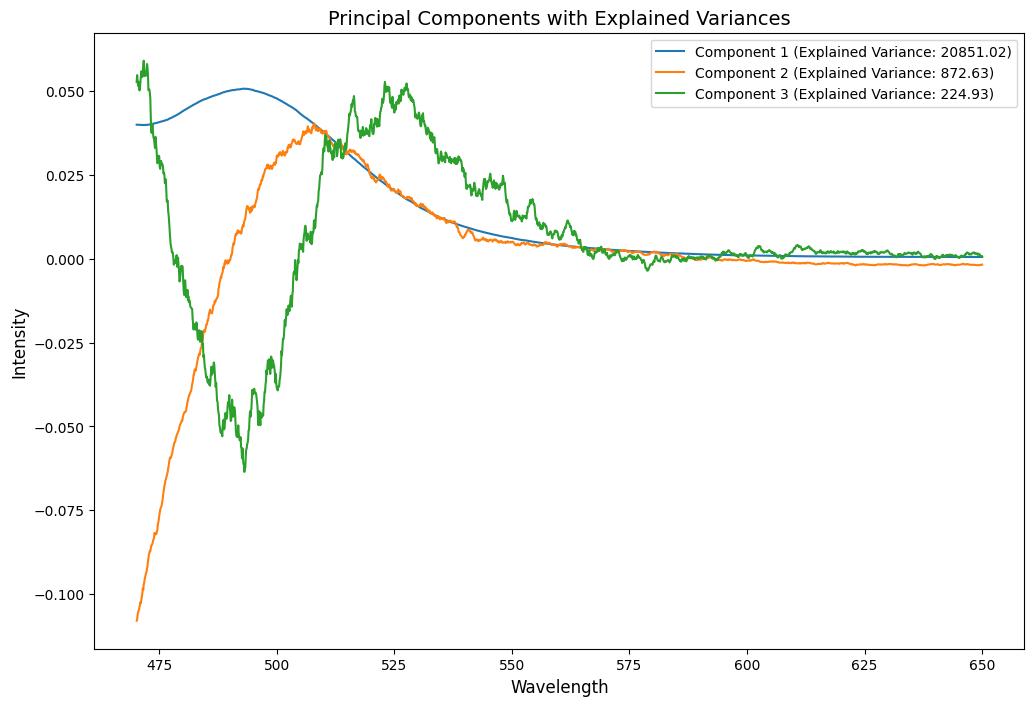

[[ 0.04001801  0.04000301  0.03999731 ...  0.00054126  0.00054089
   0.00054264]
 [-0.10796398 -0.10759229 -0.10621958 ... -0.00179498 -0.00179444
  -0.00172904]
 [ 0.05275325  0.05479876  0.05294642 ...  0.00078643  0.00063139
   0.00069687]]
[470.2 470.3 470.4 ... 649.8 649.9 650. ]
/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/component_scaling_factor_time_course.svg


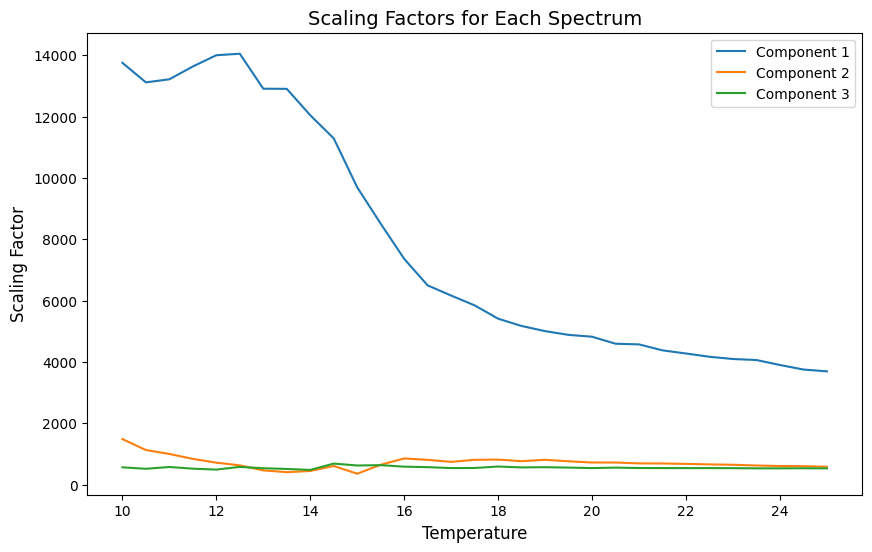

Explained variance in selected data for each component after rotation: [0.88873298 0.03348676 0.07773086]
/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/smoothed_rotated_components_with_explained_variances.svg


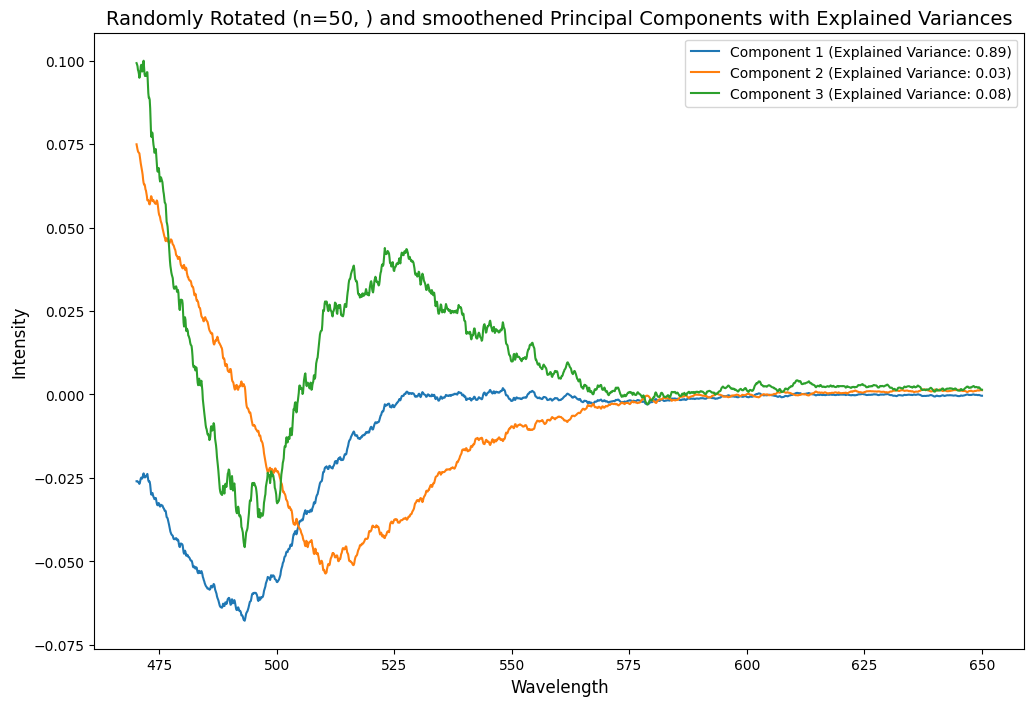

Best rotation is: [[-0.02599312 -0.02595441 -0.02597715 ... -0.00036251 -0.00038195
  -0.00038023]
 [ 0.07494032  0.07414366  0.07344647 ...  0.00131183  0.00130885
   0.00128826]
 [ 0.09925968  0.0988845   0.09837481 ...  0.00147551  0.00141497
   0.0014155 ]]
/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/smoothed_rotated_component_scaling_factor_time_course.svg


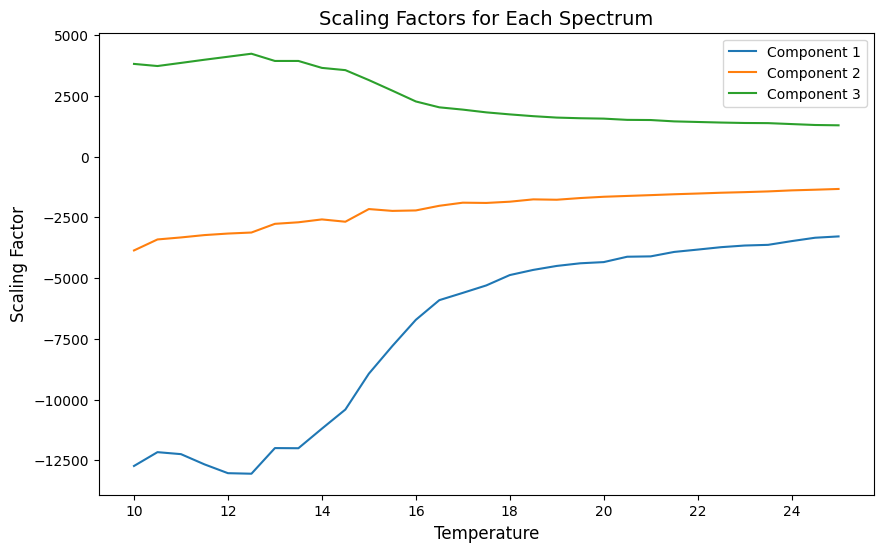

<module 'matplotlib.pyplot' from '/home/jwm/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [11]:
## Perform initial PCA

n_components=3

# Extract spectra and wavelengths
spectra = df.iloc[1:, 2:].values.astype(float)  # Convert to numpy array
# wavelengths = df.iloc[1, 2:].values.astype(float)
# wavelengths = df.columns[2:].astype(float)

def perform_pca(df, n_components):
    # Extracting the spectra data from the DataFrame
    spectra = df.values[2:, 2:]
    
    # Initialize PCA with the desired number of components
    pca = PCA(n_components=n_components)
    
    # Fit PCA to the spectra data
    pca.fit(spectra)
    
    # Get the explained variance ratio and singular values
    explained_variance_ratio = pca.explained_variance_ratio_
    singular_values = pca.singular_values_
    components = pca.components_
    
    return explained_variance_ratio, singular_values, components


explained_variance_ratio, singular_values, components = perform_pca(df, n_components)

print(explained_variance_ratio)


# Project components onto each spectrum
    
def calculate_scaling_factors(df, n_components, components):
    # Initialize scaling factors list
    scaling_factors = []
    max_length = 0
    
    for spectrum in spectra:
        # Objective function to minimize the reconstruction error
        def objective(x):
            reconstructed_spectrum = np.dot(components.T, x)
            return np.sum((spectrum - reconstructed_spectrum)**2)
        
        # Initial guess for the scaling factors
        x0 = np.ones(n_components)
        
        # Minimize the reconstruction error
        res = minimize(objective, x0)
        
        # Get the length of the optimized scaling factors
        length = len(res.x)
        max_length = max(max_length, length)
        
        # Append the optimized scaling factors to the list
        scaling_factors.append(res.x)
    
    # Pad shorter arrays with zeros to match the length of the longest array
    for i in range(len(scaling_factors)):
        scaling_factors[i] = np.pad(scaling_factors[i], (0, max_length - len(scaling_factors[i])), 'constant')
    
    return np.array(scaling_factors)



scaling_factors = calculate_scaling_factors(df, n_components, components)
# print(scaling_factors)


# Plots calculated components

def plot_components_with_explained_variances(components, explained_variance, wavelengths):
    plt.figure(figsize=(12, 8))
    for i, component in enumerate(components):
        plt.plot(wavelengths, component, label=f'Component {i+1} (Explained Variance: {explained_variance[i]:.2f})')

    plt.xlabel('Wavelength', fontsize=12)
    plt.ylabel('Intensity', fontsize=12)
    plt.title('Principal Components with Explained Variances', fontsize=14)
    plt.legend()
    plt.grid(False)
    save_path = os.path.join(figure_dir, 'components_with_explained_variances.svg')
    print(save_path)
    plt.savefig(save_path)    
    plt.show()
    return plt


plot_components_with_explained_variances(components, singular_values, wavelengths)

print(components)
print(wavelengths)


# Plots scaling factors for components for chosen spectra

def plot_scaling_factors(scaling_factors, selected_temperatures, n_components):
    plt.figure(figsize=(10, 6))
    for i in range(n_components):
        scaling_factor_values = [factor[i] for factor in scaling_factors]
        plt.plot(selected_temperatures, scaling_factor_values, label=f'Component {i+1}')

    plt.xlabel('Temperature', fontsize=12)
    plt.ylabel('Scaling Factor', fontsize=12)
    plt.title('Scaling Factors for Each Spectrum', fontsize=14)
    plt.legend()
    plt.grid(False)
    save_path = os.path.join(figure_dir, 'component_scaling_factor_time_course.svg')
    print(save_path)
    plt.savefig(save_path)   
    plt.show()
    return plt

# Example usage:
plot_scaling_factors(scaling_factors, selected_temperatures, n_components)




## Rotate randomly and smoothen, accept if total error over all spectra is diminished

def smooth_components(components, window_length=200, polyorder=5):
    smoothed_components = np.apply_along_axis(
        lambda x: savgol_filter(x, window_length, polyorder), axis=1, arr=components)
    return smoothed_components

def calculate_scaling_factors_rotated(df, n_components, best_rotation, window_length=5, polyorder=2):
    # Smooth the rotated components
    smoothed_components = smooth_components(best_rotation, window_length, polyorder)

    # Initialize scaling factors list
    scaling_factors_rotated = []
    max_length = 0
    
    for spectrum in df.to_numpy():
        # Objective function to minimize the reconstruction error
        def objective(x):
            reconstructed_spectrum = np.dot(smoothed_components.T, x)
            return np.sum((spectrum - reconstructed_spectrum)**2)
        
        # Initial guess for the scaling factors
        x0 = np.ones(n_components)
        
        # Minimize the reconstruction error
        res = minimize(objective, x0)
        
        # Get the length of the optimized scaling factors
        length = len(res.x)
        max_length = max(max_length, length)
        
        # Append the optimized scaling factors to the list
        scaling_factors_rotated.append(res.x)
    
    # Pad shorter arrays with zeros to match the length of the longest array
    for i in range(len(scaling_factors_rotated)):
        scaling_factors_rotated[i] = np.pad(scaling_factors_rotated[i], (0, max_length - len(scaling_factors_rotated[i])), 'constant')
    
    return np.array(scaling_factors_rotated)


def random_rotation(components):
    q, _ = np.linalg.qr(np.random.randn(*components.shape))
    return q

def calculate_reconstruction_error(rotated_components, spectra, window_length=50, polyorder=2):
    smoothed_components = smooth_components(rotated_components, window_length, polyorder)

    def objective(x):
        return np.sum((spectrum - np.dot(smoothed_components.T, x))**2)

    total_error = 0
    for spectrum in spectra:
        x0 = np.ones(rotated_components.shape[0])
        res = minimize(objective, x0)
        total_error += np.sum((spectrum - np.dot(smoothed_components.T, res.x))**2)

#    print("Smoothed components:", smoothed_components)
#    print("Total error:", total_error)
    
    return total_error, smoothed_components
    

def find_best_rotation(components, spectra, n_rotations=50, window_length=5, polyorder=2):
    best_rotation = None
    min_error = float('inf')
    
    for _ in range(n_rotations):
        rotation_matrix = random_rotation(components)
        rotated_components = np.dot(rotation_matrix, components)
        
        total_error, smoothed_components = calculate_reconstruction_error(rotated_components, spectra, window_length, polyorder)
        
        if total_error < min_error:
            min_error = total_error
            best_rotation = smoothed_components
    
    return best_rotation

n_rotations = 50
best_rotation = find_best_rotation(components, spectra)


    


def calculate_explained_variance(df, best_rotation):
    # Extract spectra from the DataFrame
    spectra = df.iloc[1:, 2:].values.astype(float)
    
    # Compute the covariance matrix of the spectra
    cov_matrix = np.cov(spectra, rowvar=False)
    
    # Calculate the total variance of the spectra
    total_variance = np.trace(cov_matrix)
    
    # Compute the variance explained by each component in the best rotation matrix
    component_variances = np.diag(np.dot(np.dot(best_rotation, cov_matrix), best_rotation.T))
    
    # Normalize the explained variance by dividing by the total variance
    explained_variance_rotated = component_variances / total_variance
    
    return explained_variance_rotated

explained_variance_rotated = calculate_explained_variance(df, best_rotation)
print("Explained variance in selected data for each component after rotation:", explained_variance_rotated)


def calculate_scaling_factors_rotated(df, n_components, best_rotation):
    # Initialize scaling factors list
    scaling_factors_rotated = []
    max_length = 0
    
    for spectrum in spectra:
        # Objective function to minimize the reconstruction error
        def objective(x):
            reconstructed_spectrum = np.dot(best_rotation.T, x)
            return np.sum((spectrum - reconstructed_spectrum)**2)
        
        # Initial guess for the scaling factors
        x0 = np.ones(n_components)
        
        # Minimize the reconstruction error
        res = minimize(objective, x0)
        
        # Get the length of the optimized scaling factors
        length = len(res.x)
        max_length = max(max_length, length)
        
        # Append the optimized scaling factors to the list
        scaling_factors_rotated.append(res.x)
    
    # Pad shorter arrays with zeros to match the length of the longest array
    for i in range(len(scaling_factors_rotated)):
        scaling_factors_rotated[i] = np.pad(scaling_factors_rotated[i], (0, max_length - len(scaling_factors_rotated[i])), 'constant')
    
    return np.array(scaling_factors_rotated)


# Plots final(lowest residue) smoothened rotated components

def plot_rotated_components_with_explained_variances(best_rotation, explained_variance_rotated, wavelengths):
    plt.figure(figsize=(12, 8))
    for i, component in enumerate(best_rotation):
        plt.plot(wavelengths, component, label=f'Component {i+1} (Explained Variance: {explained_variance_rotated[i]:.2f})')

    plt.xlabel('Wavelength', fontsize=12)
    plt.ylabel('Intensity', fontsize=12)
    plt.title(f'Randomly Rotated (n={n_rotations}, ) and smoothened Principal Components with Explained Variances', fontsize=14)
    plt.legend()
    plt.grid(False)
    save_path = os.path.join(figure_dir, 'smoothed_rotated_components_with_explained_variances.svg')
    print(save_path)
    plt.savefig(save_path)    
    plt.show()
    return plt


plot_rotated_components_with_explained_variances(best_rotation, explained_variance_rotated, wavelengths)

print("Best rotation is:", best_rotation)



# Plots scaling factors for smoothened rotated components for chosen spectra

def plot_scaling_factors_rotated(scaling_factors_rotated, selected_temperatures, n_components):
    plt.figure(figsize=(10, 6))
    for i in range(n_components):
        scaling_factor_rotated_values = [factor[i] for factor in scaling_factors_rotated]
        plt.plot(selected_temperatures, scaling_factor_rotated_values, label=f'Component {i+1}')

    plt.xlabel('Temperature', fontsize=12)
    plt.ylabel('Scaling Factor', fontsize=12)
    plt.title('Scaling Factors for Each Spectrum', fontsize=14)
    plt.legend()
    plt.grid(False)
    save_path = os.path.join(figure_dir, 'smoothed_rotated_component_scaling_factor_time_course.svg')
    print(save_path)
    plt.savefig(save_path)   
    plt.show()
    return plt


scaling_factors_rotated = calculate_scaling_factors_rotated(df, n_components, best_rotation)
plot_scaling_factors_rotated(scaling_factors_rotated, selected_temperatures, n_components)


